# Proejct 1: Edge Detection/Hough Transform

### What to Submit
Submit this iPython Notebook--containing all your code for the programming exercises below--on [learning suite](https://learningsuite.byu.edu/).

Your notebook file should produce the relevant plots and also provide a short write-up with answers to the questions in parts A-B.

Please also fill in here the time that each part took you:
* A1. Gradient Magnitude: <span style="color:red;">FILL IN TIME</span>
* A2. Gradient Orientation: <span style="color:red;">FILL IN TIME</span>
* A3. Laplacian Zero-crossings: <span style="color:red;">FILL IN TIME</span>
* A4. Gradient Magnitude + Zero-crossings: <span style="color:red;">FILL IN TIME</span>
* B. Hough Transform (Circles):  <span style="color:red;">FILL IN TIME</span>

Note that the images referred to and needed for this project are contained in the zip file provided (in the same directory as this notebook file).  <i>Please use the files as though they are in the same directory.  We will drop your notebook file into our folder and run it.</i>

### Programming Exercises
Make sure to read through all of the assignment and plan accordingly.  The first part is relatively easy, but you should allow adequate time for the second part.

The main goal is to investigate edge detection and the Hough transform as discussed in Sections 4.2 and 4.3 of [Szeliski](http://szeliski.org/Book "Computer Vision: Algorithms and Applications").

#### Part A: Edge Detection (32 points)
For each of the following four parts, try out your code first on the <span style="color:orange;">2D_White_Box.png</span> image, then on the more complicated <span style="color:orange;">blocks.png</span> image.

Note: Many of the images will contain negative numbers or numbers larger than 255.  Make sure you approprately scale the output images to display all of the information.  Hint: try mapping negative values to [0,128) and positive values to (128,255].

2D_White_Box.png:
![alt 2D_White_Box.png](2D_White_Box.png)

blocks.png:
![alt blocks.png](blocks.png)

<br><br><b>A1. Gradient Magnitude</b> - Compute the gradient magnitude image for a grayscale image.  Apply a suitable threshold to find edge points--play with the threshold to find the "best" solution.  How well does this seem to work?  Feel free to use any preprocessing you wish to prior to edge detection.

In [1]:
%pylab inline
from PIL import Image

white_box = array(Image.open("2D_White_Box.png"))
blocks = array(Image.open("blocks.png"))
circles = array(Image.open("circles.png"))
simplecircle = array(Image.open("simplecircle.png"))
gray_circles = (circles * [0.2126, 0.7152, 0.0722]).sum(2)
gray_simplecircle = (simplecircle * [0.2126, 0.7152, 0.0722]).sum(2)


Populating the interactive namespace from numpy and matplotlib


In [92]:
import numba

@numba.njit()
def convolution(image, kernel):
    height, width = image.shape
    kheight, kwidth = kernel.shape
    
    result = zeros((height - kheight, width - kwidth))
    for y in range(height - kheight):
        for x in range(width - kwidth):
            for dy in range(kheight):
                for dx in range(kwidth):
                    result[y, x] += image[y + dy, x + dx] * kernel[dy, dx]
    
    return result

def convolution_pad(image, kernel):
    height, width = image.shape
    kheight, kwidth = kernel.shape
    new_image = zeros((height + 2*kheight, width + 2*kwidth))
    new_image[kheight:kheight+height, kwidth:kwidth+width] = image
    return convolution(new_image, kernel)

@numba.njit()
def stamp(image, kernel):
    height, width = image.shape
    kheight, kwidth = kernel.shape
    
    result = zeros(image.shape)
    for y in range(height):
        for x in range(width):
            for dy in range(kheight):
                for dx in range(kwidth):
                    if (0 <= x + dx < width and 0 <= y + dy < height):
                        result[y, x] += image[y + dy, x + dx] * kernel[dy, dx]
    
    return result

In [3]:
import numba

@numba.njit()
def median_blur(image, times=1):
    if times > 1:
        result = median_blur(image)
        return median_blur(result, times-1)
    
    height, width = image.shape
    result = zeros((height - 2, width - 2))
    for y in range(height - 2):
        for x in range(width - 2):
            result[y, x] = median(image[y:y+3, x:x+3])
    return result           
    
def blur(image, times=1):
    kernel = array([
        [1, 2, 1],
        [2, 4, 2],
        [1, 2, 1]
    ])
    result = image
    for _ in range(times):
        result =  convolution(result, kernel) / 16
    return result.astype(np.uint8)

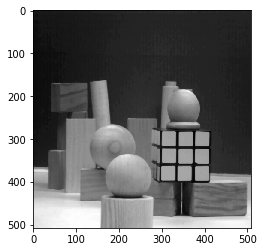

In [4]:
blurred_blocks = median_blur(blocks, 2)
plt.imshow(blurred_blocks, cmap="gray")

In [5]:
def gradient_y(image):
    kernel = array([
        [-1, -2, -1],
        [0, 0, 0],
        [1, 2, 1]
    ])
    return convolution(image, kernel)

def gradient_x(image):
    kernel = array([
        [-1, 0, 1],
        [-2, 0, 2],
        [-1, 0, 1]
    ])
    return convolution(image, kernel)

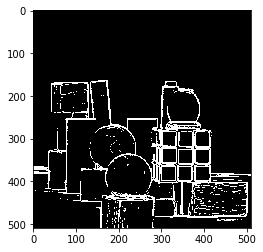

In [6]:
def gradient_magnitude(image):
    gx, gy = gradient_x(image), gradient_y(image)
    return (gx**2 + gy**2)**0.5

threshold = 60
result = gradient_magnitude(blocks)
edges = ones(result.shape)
edges[result < threshold] = 0
imshow(edges, cmap="gray")

<br><b>A2. Gradient Orientation</b> - Compute a gradient orientation image for a grayscale image.  Encode the orientations as intensity using any method you wish. (Just make sure to document it.)  Hint: use atan2(), not atan(), to do the angle calculation.

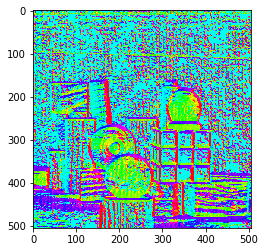

In [7]:
# Part 2. Compute the Gradient Orientation
def gradient_orientation(image):
    gx, gy = gradient_x(image), gradient_y(image)
    return arctan2(gy, gx)

# Show your results on the blocks image
result = gradient_orientation(blurred_blocks)
# The color map is hsv.
imshow(result, cmap="hsv")

<br><b>A3. Laplacian Zero-Crossings</b> - Apply a 3x3 Laplacian kernel to blocks and find the zero crossings.



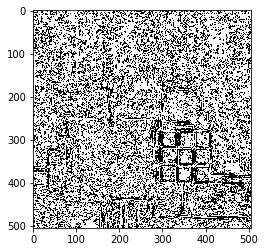

In [8]:
# Part 3. Find the Zero Crossings

"""
I will assume that to have a zero crossing, the difference must be sufficiently sharp
"""

#@numba.njit()
def zero_crossings(image):
    kernel = array([
        [1, 2, 1],
        [2, -12, 2],
        [1, 2, 1]
    ])
    laplacian = convolution(image, kernel)
    
    height, width = laplacian.shape
    result = zeros((height , width ))
    
    for y in range(height - 1):
        for x in range(width - 1):
            if (sign(laplacian[y, x]) == -sign(laplacian[y, x+1])
                or sign(laplacian[y, x]) == -sign(laplacian[y+1, x])):
                    result[y, x] = 1
    return result
    

# Show the results on blocks image
result = zero_crossings(blurred_blocks)
figure()
imshow(abs(result), cmap="gray")

<br><b>A4. Combine Gradient Magnitude and Zero-Crossings</b> - Use the gradient magnitude image computed in item 1 to select Laplacian zero-crossings in part 3 that correspond to points with gradients higher than some threshold that you determine.  Adjust your threshold to find the best solution.


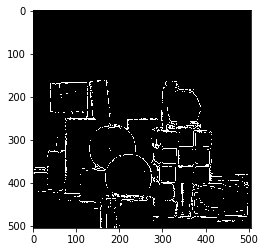

In [9]:
# Part 4. Final Solution
def final_solution(image, threshold=50):
    gradient = gradient_magnitude(image)
    crossings = zero_crossings(image)
    crossings[gradient < threshold] = 0
    return crossings


# Show the results on blocks image
result = final_solution(blurred_blocks, 60)
imshow(result, cmap="gray")

##### Part A: Write-up

<span style="color:red">Please describe your results here and any questions, etc. above.</span>

The gradient edge detector worked the best.  Using a median blur on the image helped remove much of the noise.  I also tried a Gaussian blur, but it didn't work as well.  The Laplacian zeros combined with the gradient also worked fairly well.  It has thinner edges than the gradient edge detector, but is missing many of the edges.  The Lapacian zero crossings on its own failed due to noise far from edges (as would be expected).

<br><br><br>
#### Part B: Hough Transform (68 points)
Use the Hough transform to find all of the circular shapes in a color image.  They occur in three (approximate) sizes: 32, 64, and 96 pixels in diameter.  Try it out first on the simple <span style="color:orange;">simplecircle.png</span> image, then on the more complicated <span style="color:orange;">circles.png</span> image.

After finding maxima in the accumulator(s), write out a list of positions and sizes (small, medium, or large) for each circle.  Be aware that for some of the circles the center is outside the image--you should still be able to identify where it is.

Some of the cases are tricky--don't panic if you don't get them all at first. Keep trying to get as many as possible while generatign as few possible false positives (erroneous identifications).

About 40 of the 68 points will be on how many of the circles you can detect (1-2 false positives are okay). To know what you should be shooting for, there are:
* 5 small circles (blue/cyan, light gray, purple clipped on the left, two eyes of the pumpkin).
* 12 medium circles (green one in the top left corner, orange/magenta/pink near top/left, yello, magenta, purple/cyan, medium grey in "target", med blue clipped on the left, red/white/blue on lower right).
* 3 Large circles (black in target, black/dark blue on right, and orange pumpkin).

For the <span style="color:orange;">circles.png</span> file, and each of the 3 diameters, show (1) the accumulation array and (2) the <span style="color:orange;">circles.png</span> with the detected circles outlined.  This would be a total of 6 figures (3 diameters with two plots each).

This will be graded based on how well your method performs and how innovative your solution is. **In the write-up, describe any improvements/optimizations you made from the vanilla Hough transform**.

simplecircle.png:
![alt simplecircle.png](simplecircle.png)
circles.png:
![alt circles.png](circles.png)

<Figure size 432x288 with 0 Axes>

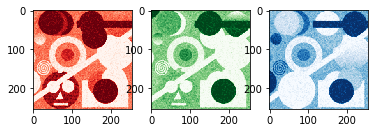

In [75]:
simplecircle = asarray(Image.open("simplecircle.png"))
circles = asarray(Image.open("circles.png"))
red_circles = array(circles[:,:,0])
red_circles = median_blur(red_circles, 1)
green_circles = array(circles[:,:,1])
green_circles = median_blur(green_circles, 1)
blue_circles = array(circles[:,:,2])
blue_circles = median_blur(blue_circles, 1)
figure()
fig, ax = subplots(1, 3)
ax[0].imshow(red_circles, cmap="Reds")
ax[1].imshow(green_circles, cmap="Greens")
ax[2].imshow(blue_circles, cmap="Blues")

<Figure size 432x288 with 0 Axes>

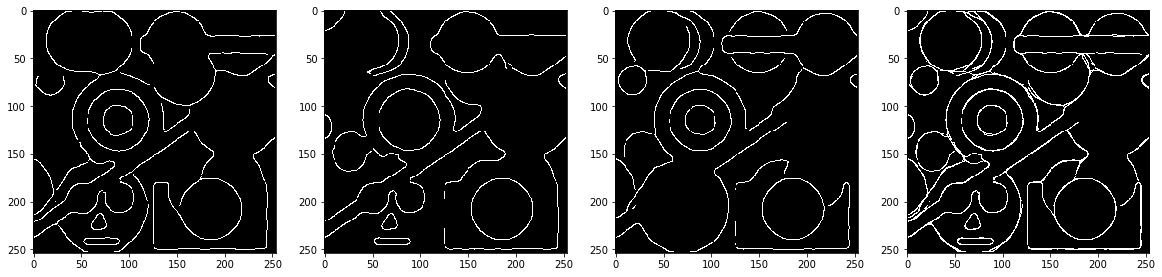

In [11]:
from skimage import feature
from skimage.color import rgb2gray
red_edges = feature.canny(red_circles, 3, low_threshold=40, high_threshold=80).astype(float)
green_edges = feature.canny(green_circles, 3, low_threshold=40, high_threshold=100).astype(float)
blue_edges = feature.canny(blue_circles, 3, low_threshold=40, high_threshold=80).astype(float)
edges = 1 - (1 - red_edges) * (1 - green_edges) * (1 - blue_edges)
figure()
fig, ax = subplots(1, 4, figsize=(20, 6))
ax[0].imshow(red_edges, cmap="gray")
ax[1].imshow(green_edges, cmap="gray")
ax[2].imshow(blue_edges, cmap="gray")
ax[3].imshow(edges, cmap="gray")

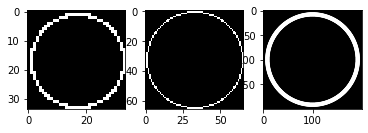

In [35]:
from skimage.transform import resize

def create_circle(radius, width=2):
    x, y = arange(-radius - width, radius + width, 1), arange(-radius - width, radius + width, 1)
    xx, yy = meshgrid(x, y)
    result = zeros(xx.shape)
    result[xx**2 + yy**2 <= (radius + width/2)**2] = 1
    result[xx**2 + yy**2 <= (radius - width/2)**2] = 0
    return result

huge_circle = create_circle(200, 30)
small_circle = create_circle(16, 1)#resize(create_circle(500, 100), (34, 34))
small_circle /= small_circle.sum()
medium_circle = create_circle(32, 1)
medium_circle /= medium_circle.sum()
large_circle = resize(create_circle(500, 50), (200, 200))
medium_circle /= medium_circle.sum()

fig, ax = subplots(1, 3)
ax[0].imshow(small_circle, cmap="gray")
ax[1].imshow(medium_circle, cmap="gray")
ax[2].imshow(large_circle, cmap="gray")

In [141]:
def hough_transform(edges, kernel):
    return convolution_pad(edges, kernel)
def get_best_circles(edges, circle, number):
    transform = hough_transform(edges, circle)
    box_width = 5
    averaged = convolution_pad(transform, ones((box_width * 2, box_width * 2))) / box_width**2 / 4
    averaged = averaged[box_width:-box_width, box_width:-box_width]

    peaks = transform > 2 * averaged
    transform[peaks == False] = 0

    @numba.njit()
    def find_maximum(peaks):
        height, width = peaks.shape
        result = zeros((height, width))
        for y in range(height - 6):
            for x in range(width - 6):
                if (3 * 7 + 3) == argmax(peaks[y:y+7, x:x+7]):
                    result[y+3, x+3] = 1
        return result

    maxima = find_maximum(transform)
    #imshow(maxima, cmap="gray")

    transform[maxima == 0] = 0
    indices = numpy.argpartition(-transform, number, axis=None)[:number]
    best_circles = [unravel_index(index, transform.shape) for index in indices]
    return best_circles

Small Circles:
Medium Circles:
Large Circles:


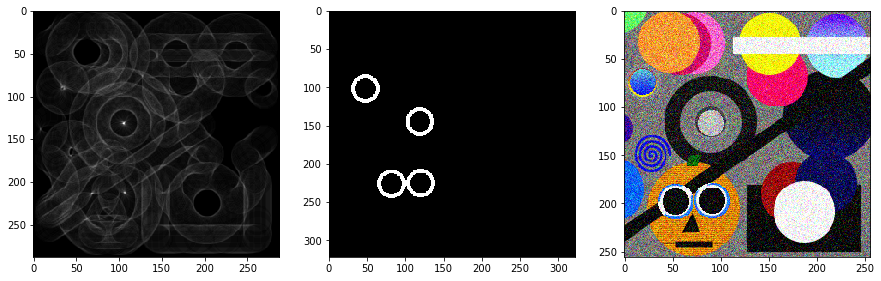

<Figure size 432x432 with 0 Axes>

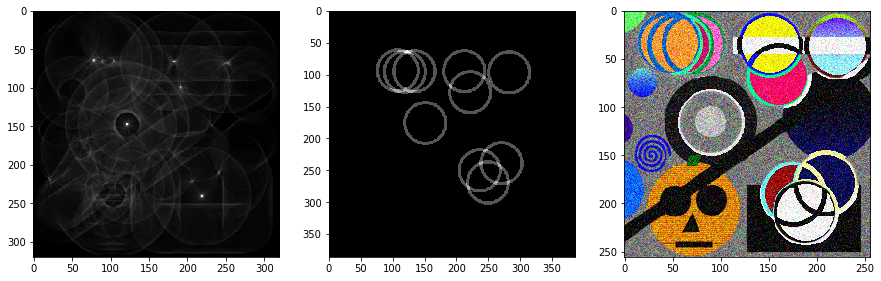

<Figure size 432x432 with 0 Axes>

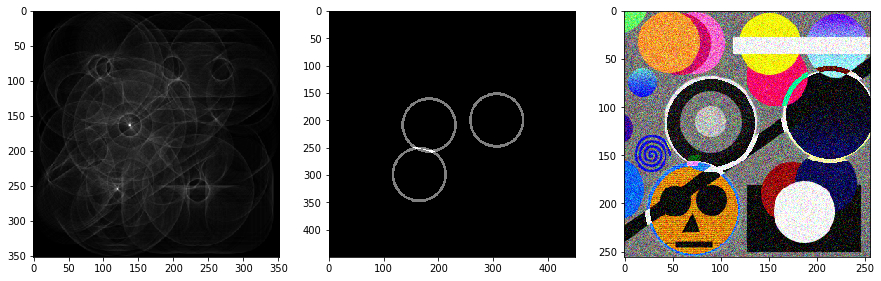

<Figure size 432x432 with 0 Axes>

In [149]:
# Part B - Hough Transform - code below
def display_circles(radius, num):
    circle = create_circle(radius, 1)
    height, width = edges.shape
    kheight, kwidth = circle.shape
    best_circles = get_best_circles(edges, circle, num)
    result = zeros((height + 2 * kheight, width + 2 * kwidth))
    for circle_center in best_circles:
        result[circle.shape[1] + circle_center[0], circle.shape[0] + circle_center[1]] = 1


    final = stamp(result, create_circle(radius, 5))
    fig, ax = subplots(1, 3, figsize=(15, 5))
    transform = hough_transform(edges, circle)
    ax[0].imshow(transform, cmap="gray")
    ax[1].imshow(final, cmap="gray")

    black_circles = (np.stack((final, final, final), axis=-1) * 255).astype(uint8)
    black_circles = black_circles[kheight-6:-kheight-4, kheight-6:-kheight-4, :]
    copy_circles = circles.copy().astype(int)
    copy_circles ^= black_circles
    copy_circles.clip(0, 255)
    copy_circles = copy_circles.astype(uint8)

    figure(figsize=(6,6))
    ax[2].imshow(copy_circles)

display_circles(16, 4)
display_circles(32, 10)
display_circles(48, 3)
# Be sure to show all of the figures required in the description above


##### Part B: Write-up

<span style="color:red">Please describe your results here and any questions, etc. above.</span>

